# Calibration of the Rahmstorf (2007) SLR Model

## Load Environment

In [110]:
import Pkg
Pkg.activate(dirname(@__DIR__))
Pkg.instantiate()

  Activating project at `~/Teaching/BEE4850/website/slides`


In [111]:
using Distributions
using StatsBase
using CSV
using DataFrames
using Optim
using Turing
using Plots
using StatsPlots
using XLSX
using Interpolations

## Load Data

In [112]:
data_path = joinpath(dirname(@__DIR__), "data")
norm_yrs = 1951:1980

sl_dat = DataFrame(CSV.File(joinpath(data_path, "sealevel", "CSIRO_Recons_gmsl_yr_2015.csv")))

rename!(sl_dat, [:Year, :GMSLR, :SD]) # rename to make columns easier to work with
sl_dat[!, :Year] .-= 0.5 # shift year to line up with years instead of being half-year 
sl_dat[!, :GMSLR] .-= mean(filter(row -> row.Year ∈ norm_yrs, sl_dat)[!, :GMSLR]) # rescale to be relative to 1880-1900 mean for consistency with temperature anomaly
sl_dat


Row,Year,GMSLR,SD
,Float64,Float64,Float64
1,1880.0,-118.157,24.2
2,1881.0,-112.557,24.2
3,1882.0,-129.357,23.0
4,1883.0,-124.057,22.8
5,1884.0,-103.157,22.2
6,1885.0,-104.657,21.9
7,1886.0,-107.057,20.8
8,1887.0,-112.657,20.8
9,1888.0,-110.557,20.8


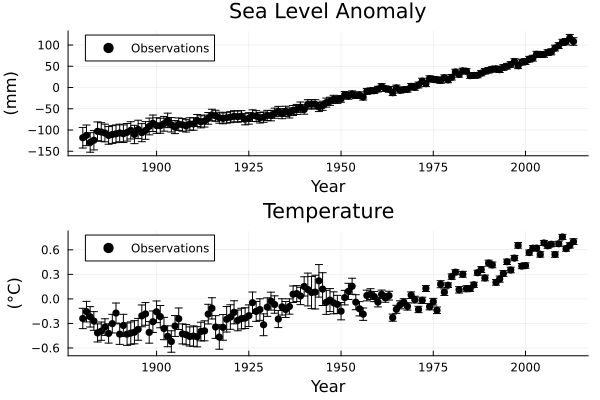

In [113]:

# load temperature data
temp_dat = DataFrame(CSV.File(joinpath(data_path, "climate", "HadCRUT.5.0.1.0.analysis.summary_series.global.annual.csv")))
rename!(temp_dat, [:Year, :Temp, :Lower, :Upper]) # rename to make columns easier to work with
filter!(row -> row.Year ∈ sl_dat[!, :Year], temp_dat) # reduce to the same years that we have SL data for
temp_normalize = mean(filter(row -> row.Year ∈ norm_yrs, temp_dat)[!, :Temp]) # get renormalization to rescale temperature to 1880-1900 mean
temp_dat[!, :Temp] .-= temp_normalize
temp_dat[!, :Lower] .-= temp_normalize
temp_dat[!, :Upper] .-=  temp_normalize

sl_plot = scatter(sl_dat[!, :Year], sl_dat[!, :GMSLR], yerr=sl_dat[!, :SD], color=:black, label="Observations", ylabel="(mm)", xlabel="Year", title="Sea Level Anomaly")

temp_plot = scatter(temp_dat[!, :Year], temp_dat[!, :Temp], yerr=(temp_dat[!, :Temp] - temp_dat[!, :Lower], temp_dat[!, :Upper] - temp_dat[!, :Temp]), color=:black, label="Observations", ylabel="(°C)", xlabel="Year", title="Temperature")

plot(sl_plot, temp_plot, layout=(2, 1))

## Model Specification

The Rahmstorf (2007) model is:

$$\frac{dH}{dt} = \alpha (T - T_0)$$

Discretizing:

$$H(t+1) = H(t) + \Delta t \alpha (T - T_0)$$

We'll set $\Delta t = 1 \text{yr}$. This means we need the following parameters:

- $\alpha$: SLR sensitivity to temperature anomalies $(mm/(yr \cdot ^\circ C))$,
- $T\_0$: Null temperature anomaly (no SLR at this temperature) $(^\circ C)$.
- $H_0 = H(0)$: Initial SL anomaly $(mm)$.

This is the **generative model**.

Simplest way to add residuals/measurement errors:

$$y_t \sim N(H(t), \sigma^2)$$

In [114]:
function rahmstorf_slr(params, temps; Δt=1)
    α, b, T₀, H₀ = params
    temp_diff = temps .- T₀
    ΔT = [0; diff(temps)]
    H = zeros(length(temps) + 1) # initialize storage
    H[1] = H₀
    for i = 2:length(H)
        H[i] = H[i-1] + α * Δt * temp_diff[i-1] + b * ΔT[i-1]
    end
    return H[2:end]
end

rahmstorf_slr (generic function with 1 method)

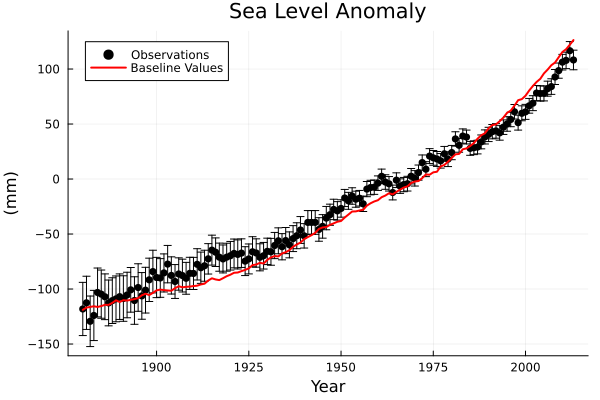

In [115]:
slr_ex = rahmstorf_slr((3.0, 8.0, -0.6, -120.0), temp_dat.Temp)
sl_plot = scatter(sl_dat[!, :Year], sl_dat[!, :GMSLR], yerr=sl_dat[!, :SD], color=:black, label="Observations", ylabel="(mm)", xlabel="Year", title="Sea Level Anomaly")
plot!(sl_plot, sl_dat[!, :Year], slr_ex, color=:red, linewidth=2, label="Baseline Values")

## Model Calibration 1: Gaussian iid Errors

In [116]:
# now the params include the standard deviation of the error model as well
function gaussian_iid_homosked(params, temp_dat, slr_dat, Δt=1.0)
    α, b, T₀, H₀, σ = params 
    slr_sim = rahmstorf_slr((α, b, T₀, H₀), temp_dat; Δt = Δt)
    ll = sum(logpdf.(Normal.(slr_sim, σ), slr_dat))
    return ll
end

gaussian_iid_homosked((4.6, 50.0, -0.5, -100.0, 5.0), temp_dat.Temp, sl_dat.GMSLR)

-8874.472323023909

In [117]:
low_bds = [0.0, -100.0, -5.0, -200.0, 0.0]
up_bds = [10.0, 100.0, 0.0, 0.0, 50.0]
p₀ = [3.4, 20.0, -0.5, -100.0, 10.0]

mle_optim = optimize(p -> -gaussian_iid_homosked(p, temp_dat.Temp, sl_dat.GMSLR), low_bds, up_bds, p₀)
p_mle = mle_optim.minimizer

5-element Vector{Float64}:
    1.9954491263556067
   -7.531720172168937
   -0.8657256422225121
 -117.60853103544478
    5.837542474551414

In [118]:
rahmstorf_homogauss_mle = rahmstorf_slr(p_mle, temp_dat.Temp)


134-element Vector{Float64}:
 -116.35838317756556
 -115.57099317163348
 -113.80369210845214
 -112.23099107864499
 -110.23454730682374
 -109.45392169294495
 -108.79168143354109
 -107.32002185169173
 -107.09601755178424
 -106.6895289311967
    ⋮
   81.02621423657114
   84.30750091691806
   87.22436356816803
   90.98330316458731
   93.0668769172916
   95.67532357715741
   99.70322535899919
  102.43559944097373
  105.21406676172056

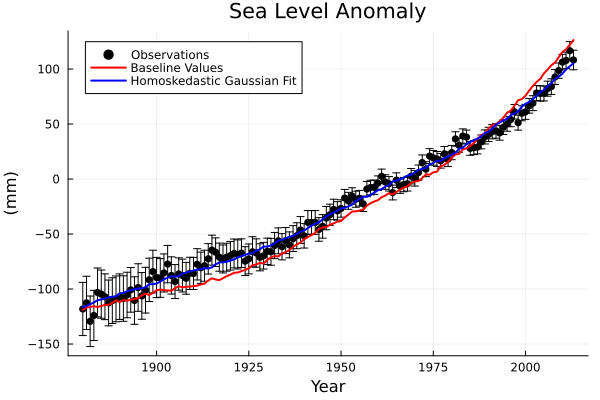

In [119]:
plot!(sl_plot, sl_dat[!, :Year], rahmstorf_homogauss_mle, color=:blue, linewidth=2, label="Homoskedastic Gaussian Fit")

In [120]:
function gaussian_iid_ar(params, temp_dat, slr_dat, slr_err, Δt=1.0)
    α, b, T₀, H₀, ρ, σ = params 
    slr_sim = rahmstorf_slr((α, b, T₀, H₀), temp_dat; Δt = Δt)

    function ar_covariance_mat(σ, ρ, y_err)
        H = abs.((1:length(y_err)) .- (1:(length(y_err)))') # compute the outer product to get the correlation lags
        ζ_var = σ^2 / (1-ρ^2)
        Σ = ρ.^H * ζ_var
        # for i in 1:length(y_err)
        #     Σ[i, i] += y_err[i]^2
        #  end

        return Σ
    end

    # whiten residuals
    Σ = ar_covariance_mat(σ, ρ, slr_err)
    residuals = slr_dat - slr_sim
    ll = logpdf(MvNormal(zeros(length(slr_dat)), Σ), residuals)
    return ll
end


gaussian_iid_ar (generic function with 2 methods)

In [121]:
low_bds = [0.0, -100.0, -5.0, -200.0, -1.0, 0.0]
up_bds = [10.0, 100.0, 0.0, 0.0, 1.0, 50.0]
p₀ = [3.4, 20.0, -0.5, -100.0, 0.0, 10.0]

mle_optim = optimize(p -> -gaussian_iid_ar(p, temp_dat.Temp, sl_dat.GMSLR, sl_dat.SD), low_bds, up_bds, p₀)
p_mle2 = mle_optim.minimizer
@show p_mle;
@show p_mle2;

p_mle = [1.9954491263556067, -7.531720172168937, -0.8657256422225121, -117.60853103544478, 5.837542474551414]
p_mle2 = [1.9302376501126903, -3.14314499039516, -0.8779630539108811, -117.1557215574112, 0.5274575063654862, 4.969822166799868]


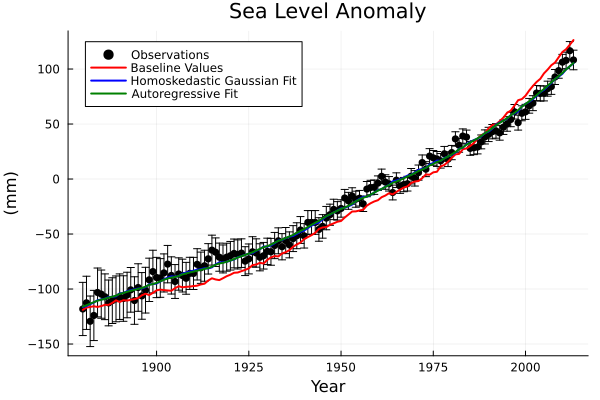

In [122]:
rahmstorf_ar_mle = rahmstorf_slr(p_mle2, temp_dat.Temp)
plot!(sl_plot, sl_dat[!, :Year], rahmstorf_ar_mle, color=:green, linewidth=2, label="Autoregressive Fit")

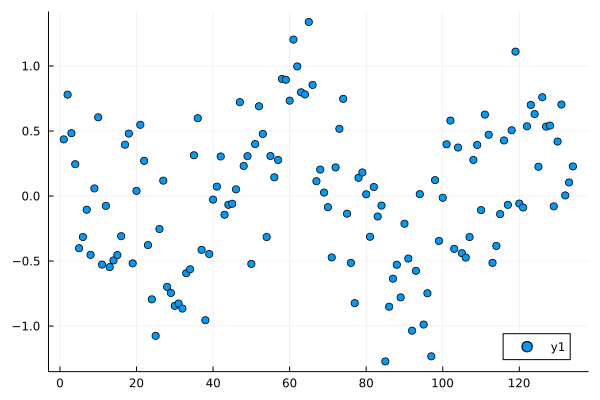

In [123]:
scatter(rahmstorf_ar_mle - rahmstorf_homogauss_mle)

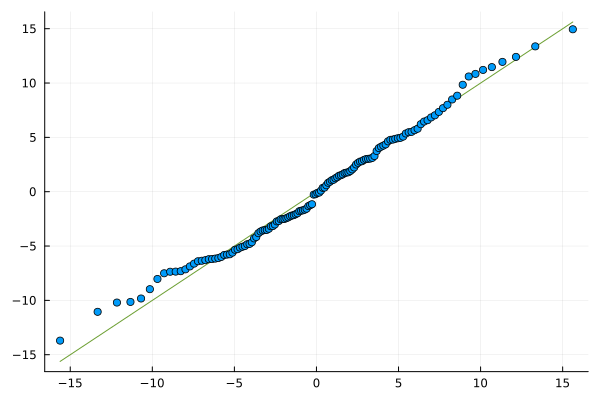

In [124]:
resids_homogauss = sl_dat.GMSLR - rahmstorf_homogauss_mle
qqnorm(resids_homogauss)


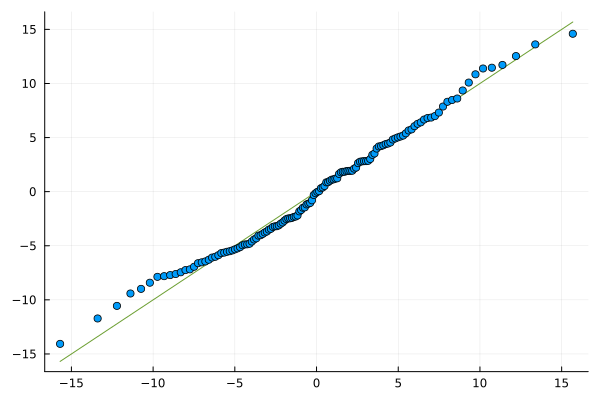

In [125]:
resids_ar = sl_dat.GMSLR - rahmstorf_ar_mle
qqnorm(resids_ar)

In [126]:
pacf_homogauss = pacf(resids_homogauss, 1:5)

5-element Vector{Float64}:
  0.5192505198690146
  0.08329400514537694
  0.01867936459019353
  0.04266165780968207
 -0.08903475089498139

In [127]:
pacf_ar = pacf(resids_ar, 1:5)

5-element Vector{Float64}:
  0.5308290427109937
  0.09178983893170273
  0.035115508775906315
  0.047473969138684555
 -0.07752525965199511

## Projections

In [128]:

rcpdf = XLSX.readtable(joinpath(data_path, "climate", "cmip6_temps.xlsx"), "data") |> DataFrame

# select only rows and columns with scenario names and data   
select!(rcpdf, Not([:Model, :Region, :Variable, :Unit, :Notes]))
rcpdf = rcpdf[1:5, :]


Row,Scenario,2005.0,2010.0,2020.0,2030.0,2040.0,2050.0,2060.0,2070.0,2080.0,2090.0,2100.0
,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any
1,SSP3-Baseline,0.913386,0.988055,1.22575,1.52381,1.86419,2.20251,2.55093,2.91152,3.28435,3.67242,4.0711
2,SSP4-Baseline,0.913386,0.988562,1.23721,1.53287,1.87389,2.21631,2.54615,2.87451,3.20099,3.49421,3.75829
3,SSP1-Baseline,0.913386,0.988441,1.22283,1.50579,1.77074,2.02206,2.24641,2.46035,2.66872,2.85621,3.01774
4,SSP2-Baseline,0.913386,0.988977,1.24141,1.48262,1.7615,2.05281,2.35626,2.68133,3.02315,3.38796,3.76329
5,SSP5-Baseline,0.913386,0.989124,1.2658,1.60296,2.01275,2.48049,2.9755,3.50379,4.0499,4.5757,5.05197


In [129]:
# reformat scenario names to SSPn-x.x
rcpdf[!, :Scenario] = first.(rcpdf[!, :Scenario], 4)
# sort by scenarios
sort!(rcpdf, :Scenario)

Row,Scenario,2005.0,2010.0,2020.0,2030.0,2040.0,2050.0,2060.0,2070.0,2080.0,2090.0,2100.0
,String,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any
1,SSP1,0.913386,0.988441,1.22283,1.50579,1.77074,2.02206,2.24641,2.46035,2.66872,2.85621,3.01774
2,SSP2,0.913386,0.988977,1.24141,1.48262,1.7615,2.05281,2.35626,2.68133,3.02315,3.38796,3.76329
3,SSP3,0.913386,0.988055,1.22575,1.52381,1.86419,2.20251,2.55093,2.91152,3.28435,3.67242,4.0711
4,SSP4,0.913386,0.988562,1.23721,1.53287,1.87389,2.21631,2.54615,2.87451,3.20099,3.49421,3.75829
5,SSP5,0.913386,0.989124,1.2658,1.60296,2.01275,2.48049,2.9755,3.50379,4.0499,4.5757,5.05197


In [130]:
rcp_dat = zeros(nrow(rcpdf), 2100 - 1880 + 1)
split_idx = 2013 - 1880 + 1

134

In [131]:
rcp_dat[:, 1:split_idx] .= temp_dat.Temp'
rcp_dat

5×221 Matrix{Float64}:
 -0.239226  -0.15564  -0.218924  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 -0.239226  -0.15564  -0.218924     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 -0.239226  -0.15564  -0.218924     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 -0.239226  -0.15564  -0.218924     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 -0.239226  -0.15564  -0.218924     0.0  0.0  0.0  0.0  0.0  0.0  0.0

In [132]:

for (i, row) in enumerate(eachrow(rcpdf))
    yrs = collect(2013:2100)
    xs = collect(2010:10:2100)
    interp = LinearInterpolation(xs, collect(rcpdf[i, 3:end]))
    rcp_dat[i, split_idx:end] = interp.(yrs)
end
rcp_dat = DataFrame(rcp_dat, string.(collect(1880:2100)))
rcp_dat.Scenario = rcpdf.Scenario
rcp_dat

Row,1880,1881,1882,1883,1884,1885,1886,1887,1888,1889,1890,1891,1892,1893,1894,1895,1896,1897,1898,1899,1900,1901,1902,1903,1904,1905,1906,1907,1908,1909,1910,1911,1912,1913,1914,1915,1916,1917,1918,1919,1920,1921,1922,1923,1924,1925,1926,1927,1928,1929,1930,1931,1932,1933,1934,1935,1936,1937,1938,1939,1940,1941,1942,1943,1944,1945,1946,1947,1948,1949,1950,1951,1952,1953,1954,1955,1956,1957,1958,1959,1960,1961,1962,1963,1964,1965,1966,1967,1968,1969,1970,1971,1972,1973,1974,1975,1976,1977,1978,1979,⋯
,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,⋯
1,-0.239226,-0.15564,-0.218924,-0.269868,-0.415714,-0.394518,-0.344298,-0.42218,-0.302773,-0.17329,-0.430252,-0.324709,-0.430953,-0.418013,-0.407158,-0.372146,-0.207401,-0.183194,-0.409186,-0.278828,-0.157873,-0.216823,-0.362378,-0.45672,-0.520955,-0.331145,-0.242533,-0.427552,-0.437265,-0.459159,-0.454418,-0.462599,-0.399067,-0.390547,-0.185986,-0.115238,-0.343604,-0.466414,-0.347978,-0.248912,-0.221975,-0.164071,-0.262622,-0.241325,-0.235456,-0.205819,-0.0462295,-0.152799,-0.130156,-0.316151,-0.100199,-0.0267918,-0.0688557,-0.245738,-0.0977309,-0.129453,-0.092915,0.057407,0.0644052,0.0358088,0.152542,0.114735,0.078012,0.08302,0.220711,0.119694,-0.0422069,-0.0145996,-0.0480553,-0.0671963,-0.150016,0.015452,0.0919605,0.154237,-0.0401443,-0.120704,-0.18656,0.041271,0.0589734,0.0286011,-0.0388811,0.0566085,0.0125515,0.0398,-0.229261,-0.127782,-0.0722787,-0.0409104,-0.0920264,0.0452392,-0.00850064,-0.129327,-0.0172212,0.126539,-0.0959314,-0.0341483,-0.139256,0.179694,0.0818617,0.167464,⋯
2,-0.239226,-0.15564,-0.218924,-0.269868,-0.415714,-0.394518,-0.344298,-0.42218,-0.302773,-0.17329,-0.430252,-0.324709,-0.430953,-0.418013,-0.407158,-0.372146,-0.207401,-0.183194,-0.409186,-0.278828,-0.157873,-0.216823,-0.362378,-0.45672,-0.520955,-0.331145,-0.242533,-0.427552,-0.437265,-0.459159,-0.454418,-0.462599,-0.399067,-0.390547,-0.185986,-0.115238,-0.343604,-0.466414,-0.347978,-0.248912,-0.221975,-0.164071,-0.262622,-0.241325,-0.235456,-0.205819,-0.0462295,-0.152799,-0.130156,-0.316151,-0.100199,-0.0267918,-0.0688557,-0.245738,-0.0977309,-0.129453,-0.092915,0.057407,0.0644052,0.0358088,0.152542,0.114735,0.078012,0.08302,0.220711,0.119694,-0.0422069,-0.0145996,-0.0480553,-0.0671963,-0.150016,0.015452,0.0919605,0.154237,-0.0401443,-0.120704,-0.18656,0.041271,0.0589734,0.0286011,-0.0388811,0.0566085,0.0125515,0.0398,-0.229261,-0.127782,-0.0722787,-0.0409104,-0.0920264,0.0452392,-0.00850064,-0.129327,-0.0172212,0.126539,-0.0959314,-0.0341483,-0.139256,0.179694,0.0818617,0.167464,⋯
3,-0.239226,-0.15564,-0.218924,-0.269868,-0.415714,-0.394518,-0.344298,-0.42218,-0.302773,-0.17329,-0.430252,-0.324709,-0.430953,-0.418013,-0.407158,-0.372146,-0.207401,-0.183194,-0.409186,-0.278828,-0.157873,-0.216823,-0.362378,-0.45672,-0.520955,-0.331145,-0.242533,-0.427552,-0.437265,-0.459159,-0.454418,-0.462599,-0.399067,-0.390547,-0.185986,-0.115238,-0.343604,-0.466414,-0.347978,-0.248912,-0.221975,-0.164071,-0.262622,-0.241325,-0.235456,-0.205819,-0.0462295,-0.152799,-0.130156,-0.316151,-0.100199,-0.0267918,-0.0688557,-0.245738,-0.0977309,-0.129453,-0.092915,0.057407,0.0644052,0.0358088,0.152542,0.114735,0.078012,0.08302,0.220711,0.119694,-0.0422069,-0.0145996,-0.0480553,-0.0

In [133]:
@show p_mle2;
@show p_mle;

p_mle2 = [1.9302376501126903, -3.14314499039516, -0.8779630539108811, -117.1557215574112, 0.5274575063654862, 4.969822166799868]
p_mle = [1.9954491263556067, -7.531720172168937, -0.8657256422225121, -117.60853103544478, 5.837542474551414]


In [134]:
n = 10_000
yrs = 1880:2100
rahmstorf_iid_proj_ssp5 = zeros(n, length(yrs))
for i = 1:n 
    ε = rand(Normal(0, p_mle[end]), length(yrs))
    rahmstorf_iid_proj_ssp5[i, :] = rahmstorf_slr(p_mle[1:end-1], collect(rcp_dat[5, 1:end-1])) .+ ε
end
rahmstorf_iid_proj_q = mapslices(col -> quantile(col, [0.025, 0.5, 0.975]), rahmstorf_iid_proj_ssp5; dims=1)

3×221 Matrix{Float64}:
 -127.843  -127.326  -125.058  …  684.453  695.658  707.166  718.317
 -116.47   -115.664  -113.687     695.74   706.963  718.376  729.809
 -104.866  -103.979  -102.249     707.279  718.406  729.683  741.419

In [139]:
rahmstorf_ar_proj_ssp5 = zeros(n, length(yrs))

H = abs.((1:length(yrs)) .- (1:(length(yrs)))') # compute the outer product to get the correlation lags
ζ_var = p_mle2[end]^2 / (1-p_mle2[end-1]^2)
Σ = p_mle2[end-1].^H * ζ_var

for i = 1:n 
    ε = rand(MvNormal(zeros(length(yrs)), Σ))
    rahmstorf_ar_proj_ssp5[i, :] = rahmstorf_slr(p_mle2[1:end-2], collect(rcp_dat[5, 1:end-1])) .+ ε
end
rahmstorf_ar_proj_q = mapslices(col -> quantile(col, [0.025, 0.5, 0.975]), rahmstorf_ar_proj_ssp5; dims=1)

3×221 Matrix{Float64}:
 -127.524  -126.238  -124.859  …  684.757  695.699  706.743  718.517
 -116.048  -114.864  -113.481     696.011  707.283  718.446  729.818
 -104.403  -103.644  -102.068     707.743  718.647  729.839  741.401

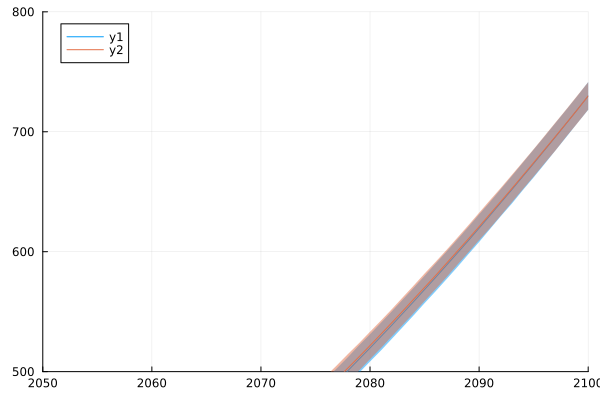

In [136]:
plot(1880:2100, rahmstorf_iid_proj_q[2, :], ribbon=(rahmstorf_iid_proj_q[2, :] - rahmstorf_iid_proj_q[1, :], rahmstorf_iid_proj_q[3, :] - rahmstorf_iid_proj_q[2, :]))
plot!(1880:2100, rahmstorf_ar_proj_q[2, :], ribbon=(rahmstorf_ar_proj_q[2, :] - rahmstorf_ar_proj_q[1, :], rahmstorf_ar_proj_q[3, :] - rahmstorf_ar_proj_q[2, :]))
ylims!((500, 800))
xlims!((2050, 2100))

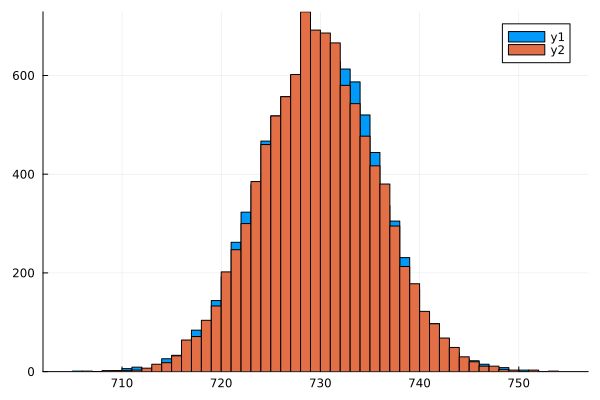

In [137]:
histogram(rahmstorf_ar_proj_ssp5[:, end])
histogram!(rahmstorf_iid_proj_ssp5[:, end])